In [1]:
import pandas as pd
import yfinance as yf
import quantstats as qs


# LEI

In [2]:
# PARAMS
raw_5y = 'M -5.5577130528587 71.98542 L 4.8629989212513 69.84432000000001 L 15.631067961165 68.58617999999998 L 26.399137001079 66.48017999999999 L 36.125134843581 67.48794000000001 L 46.893203883495 65.30394000000001 L 57.313915857605 67.82412 L 68.081984897519 66.55584000000002 L 78.502696871629 64.44984 L 89.270765911543 66.89436 L 100.03883495146 64.85076000000001 L 110.45954692557 72.76542 L 121.22761596548 77.376 L 131.64832793959 82.73850000000002 L 142.4163969795 91.67496 L 153.18446601942 94.71462 L 162.91046386192 95.51256000000001 L 173.67853290183 97.74960000000002 L 184.09924487594 99.91956000000002 L 194.86731391586 103.56372000000002 L 205.28802588997 105.74694000000002 L 216.05609492988 107.86464000000001 L 226.8241639698 114.20682 L 237.24487594391 117 L 248.01294498382 115.60302 L 258.43365695793 116.3019 L 269.20172599784 109.29126 L 279.96979503776 111.40896000000001 L 290.04314994606 151.15542 L 300.81121898598 192.14754 L 311.23193096009 178.98192 L 322 163.5777 L 332.42071197411 152.35974 L 343.18878101402 144.08784 L 353.95685005394 138.57012 L 364.37756202805 131.65152 L 375.14563106796 126.06204 L 385.56634304207 120.48816000000001 L 396.33441208198 119.77602 L 407.1024811219 120.46944 L 416.8284789644 71.80368000000001 L 427.59654800432 20.751119999999986 L 438.01725997843 28.48404000000002 L 448.78532901834 43.06614000000002 L 459.20604099245 50.18442000000002 L 469.97411003236 52.239720000000005 L 480.74217907228 55.45877999999999 L 491.16289104639 57.27384000000001 L 501.9309600863 59.170019999999994 L 512.35167206041 60.935159999999996 L 523.11974110032 83.57154000000003 L 533.88781014024 77.9649 L 543.61380798274 88.06044 L 554.38187702265 95.75202000000002 L 564.80258899676 108.16728 L 575.57065803668 118.35096 L 585.99137001079 130.37934 L 596.7594390507 136.26756 L 607.52750809061 141.54113999999998 L 617.94822006472 152.00406 L 628.71628910464 164.27268 L 639.13700107875 174.53592'
lastest_5_values= [-2.47,-3.15,-4.49,-6.06,-7.38]

# MAIN
raw_target = raw_5y
raw_target = raw_target[2:]+' '
raw_trans = [-float(i.split(' ')[-2]) for i in raw_target.split('L')]
df_raw_trans = pd.DataFrame(raw_trans,columns=['LEI(YoY)_raw'])
df_raw_trans.index = pd.date_range(end='2022-12-31', periods=len(df_raw_trans), freq='M')
df_raw_trans.index.name = 'Date'

# FITTING
sp_raw_trans = df_raw_trans.tail(5)
sp_raw_trans['LEI(YoY)'] = lastest_5_values

sp_raw_trans_diff = sp_raw_trans.diff()
slopes = sp_raw_trans_diff['LEI(YoY)']/sp_raw_trans_diff['LEI(YoY)_raw']
intercepts = sp_raw_trans['LEI(YoY)'] - sp_raw_trans['LEI(YoY)_raw'] * slopes

slopes = slopes.bfill()
intercepts = intercepts.bfill()

# TRANS
intercepts_real = intercepts.round()
if intercepts_real.nunique() != 1:
    raise ValueError('Error in intercept restore')
    
slopes_real = (sp_raw_trans['LEI(YoY)']-intercepts_real)/sp_raw_trans['LEI(YoY)_raw']
slopes_real = slopes_real.round(4)
if slopes_real.nunique() != 1:
    raise ValueError('Error in slope restore')
    
# CONVERT
df_raw_trans['LEI(YoY)_restored'] = df_raw_trans['LEI(YoY)_raw']*slopes_real.iloc[0] + intercepts_real.iloc[0]
df_raw_trans['LEI(YoY)_restored'] /= 100

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [3]:
df_raw_trans = pd.read_csv('US Conference Board Leading Economic Index.csv', index_col='Date')
df_raw_trans.index = pd.to_datetime(df_raw_trans.index)

In [4]:
LEI_df = pd.DataFrame(df_raw_trans)
LEI_df['High'] = 0.07 #historical data
LEI_df['Low'] = -0.03

In [5]:
'''Peaks and troughs'''
peak = 0
peaks = []
l_peak = []
l_peaks = 0
trough = 0
troughs = []
for _,row in LEI_df.iterrows():
    if row['LEI(YoY)_restored']>row['High'] and row['LEI(YoY)_restored']>peak:
        peak = row['LEI(YoY)_restored']
        thorugh = 0
        peaks.append(peak)
        troughs.append(trough)
    elif row['LEI(YoY)_restored']<row['Low'] and row['LEI(YoY)_restored']<trough:
        peak = 0
        trough = row['LEI(YoY)_restored']
        peaks.append(peak)
        troughs.append(trough)
    else:
        peaks.append(peak)
        troughs.append(trough)

LEI_df['peak'] = peaks
LEI_df['trough'] = troughs
LEI_df['slope'] = LEI_df['LEI(YoY)_restored'].pct_change()


In [6]:
conditions = []
condition = 0
targets = []
target = 0

for _,row in LEI_df.iterrows():
    if row['LEI(YoY)_restored'] < 0 and row['slope']>0:
        condition = 1 # Decline
        target = ['XLP']
    elif row['LEI(YoY)_restored'] < 0 and row['slope']<0:
        condition = 2 # Recovery
        target = ['XLB','XLY']
    elif row['LEI(YoY)_restored'] > 0 and row['peak'] == 0 and row['slope']>=0:
        condition = 5 # Rebound
        target = ['XLK','XLU']
    elif row['LEI(YoY)_restored'] > 0 and row['peak'] == 0 and row['slope']<=0:
        condition = 4 # Late
        target = ['XLK','XLV']
    elif row['LEI(YoY)_restored'] > 0 and row['peak']>0:
        condition = 3 #Early
        target = ['XLE','XLF','XLI']
    else:
        condition = condition
        target = target

    conditions.append(condition)
    targets.append(target)
LEI_df['condition'] = conditions
LEI_df['targets'] = targets



<AxesSubplot:xlabel='Date'>

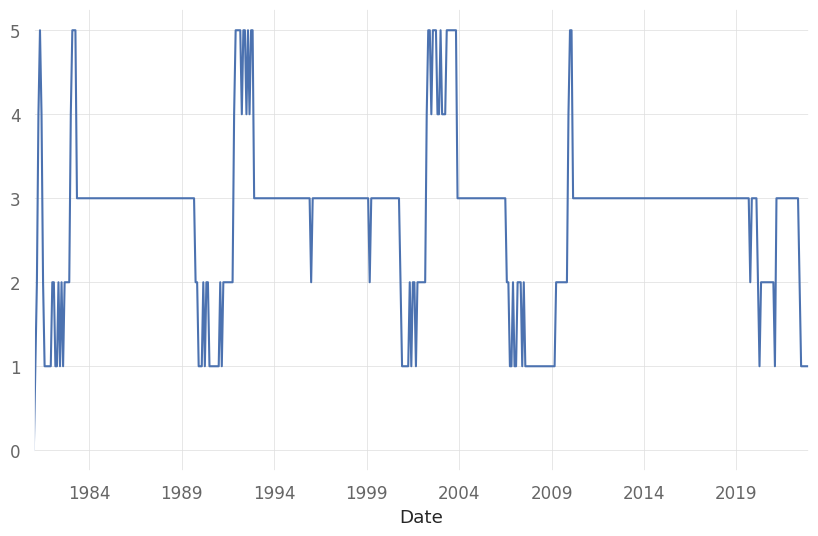

In [7]:
LEI_df['condition'].plot()

# Backtesting

In [8]:
universe_= ['XLE','XLF','XLK','XLV','XLI','XLY','XLP','XLU','XLB']
df_price = yf.download(universe_)
df_return = df_price['Adj Close'].pct_change().dropna()

[*********************100%***********************]  9 of 9 completed


In [9]:
LEI_df = LEI_df[1:]

In [10]:
LEI_db = pd.DataFrame(columns = df_return.columns, index = LEI_df.index)
weight = 0
for _,row in LEI_df.iterrows():
    targets = row['targets']
    weight = 1/len(row['targets']) 
    for col in targets:
        LEI_db[col][row.name] = weight 
LEI_db = LEI_db.fillna(0)


In [11]:
df_asset = df_return
df_tar_m = LEI_db
temp = df_asset.join(df_tar_m, lsuffix='_right')
df_tar_m_fill = temp.ffill()[df_tar_m.columns]
df_tar_m_fill = df_tar_m_fill.dropna(how='all')
df_strat = (df_asset[df_tar_m_fill.columns]*df_tar_m_fill).sum(axis=1)

In [12]:
market = yf.download(['SPY'])['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               1998-12-23  1998-12-23
End Period                 2023-03-31  2023-03-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          829.89%     410.32%
CAGR﹪                     9.62%       6.94%

Sharpe                     0.55        0.44
Prob. Sharpe Ratio         99.65%      98.46%
Smart Sharpe               0.52        0.42
Sortino                    0.78        0.62
Smart Sortino              0.74        0.59
Sortino/√2                 0.55        0.44
Smart Sortino/√2           0.52        0.42
Omega                      1.11        1.11

Max Drawdown               -49.29%     -55.19%
Longest DD Days            1141        2404
Volatility (ann.)          20.5%       19.75%
R^2                        0.7         0.7
Information Ratio          0.01        0.01
Calmar                     0.2        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-01-29,2020-03-23,2021-03-15,1141,-49.285734,-41.476145
2,2002-03-20,2002-10-09,2004-01-16,667,-40.103601,-35.052304
3,2008-09-15,2009-03-09,2009-11-16,427,-32.387546,-31.272882
4,2011-05-02,2011-10-03,2012-09-14,501,-28.457810,-25.813002
5,2001-02-13,2001-09-21,2002-02-26,378,-26.964859,-23.214534


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


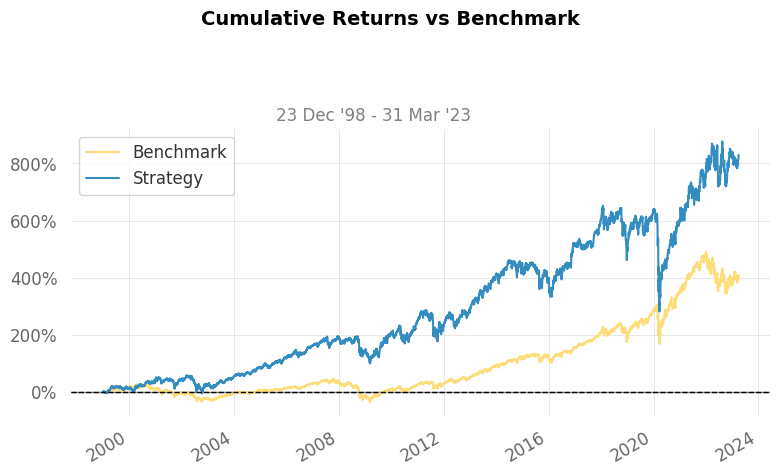

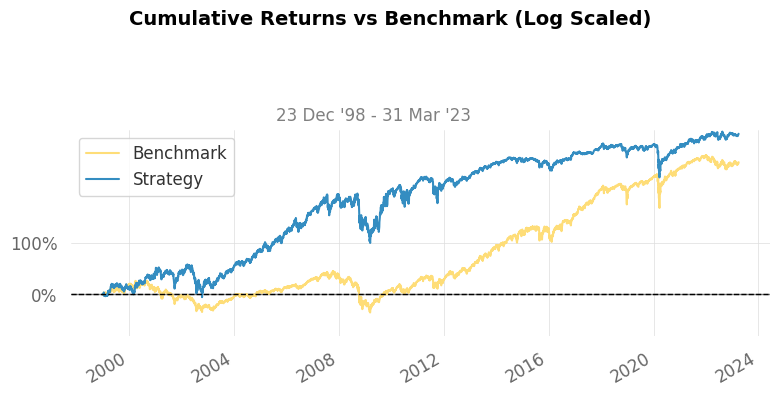

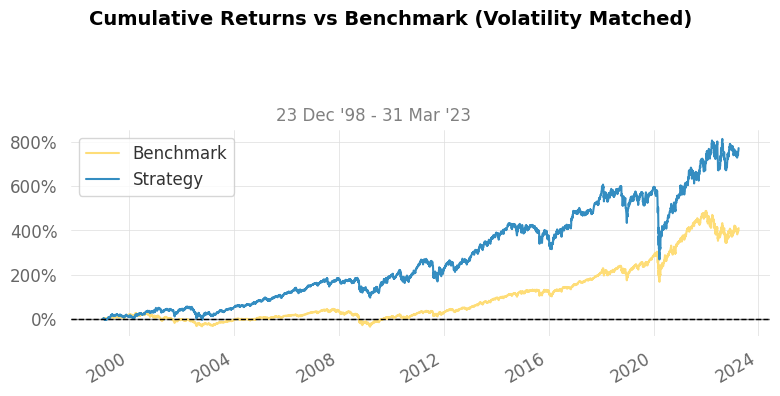

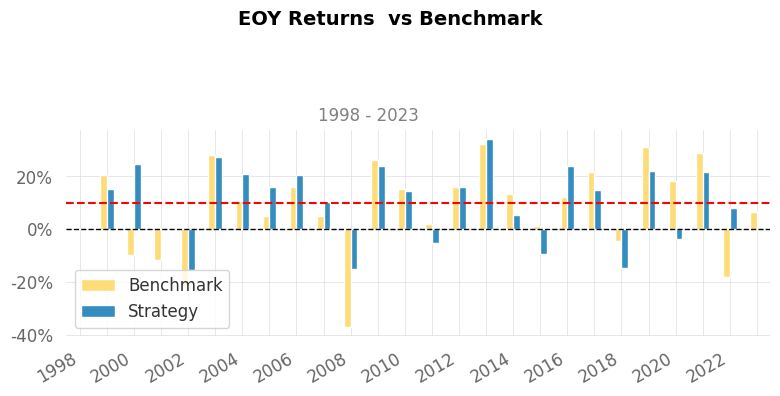

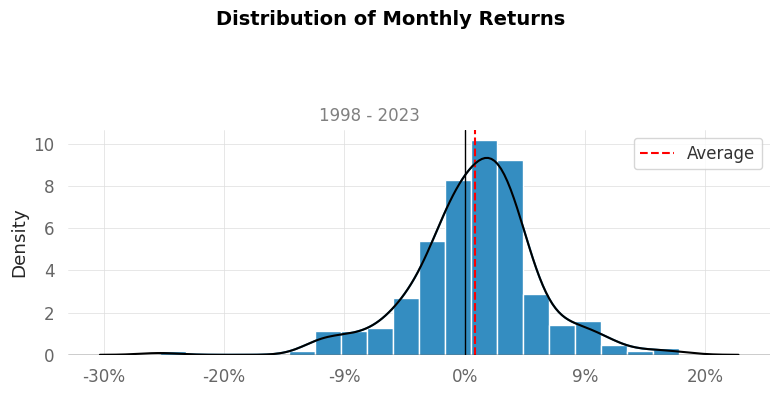

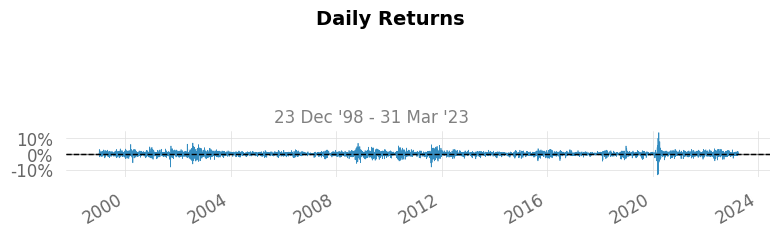

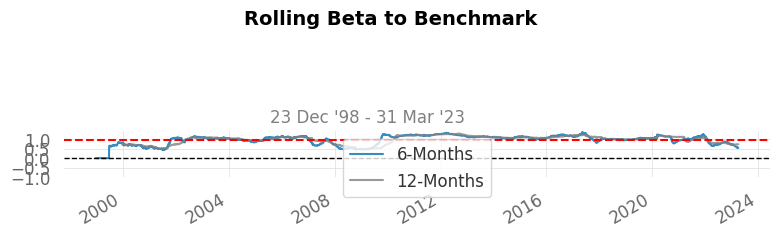

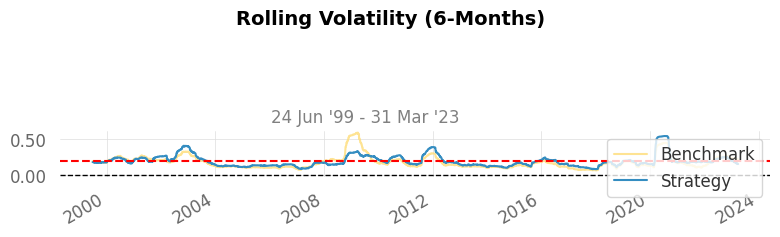

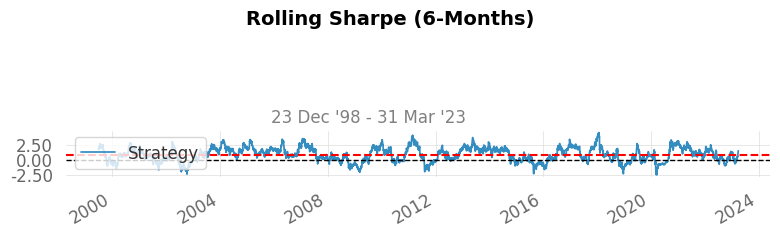

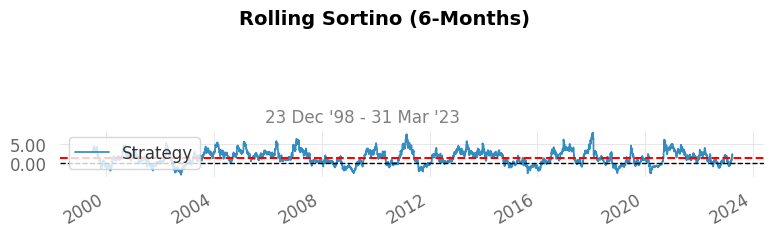

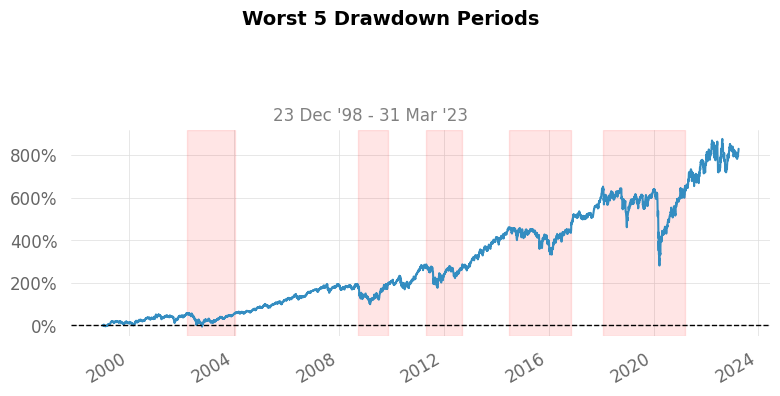

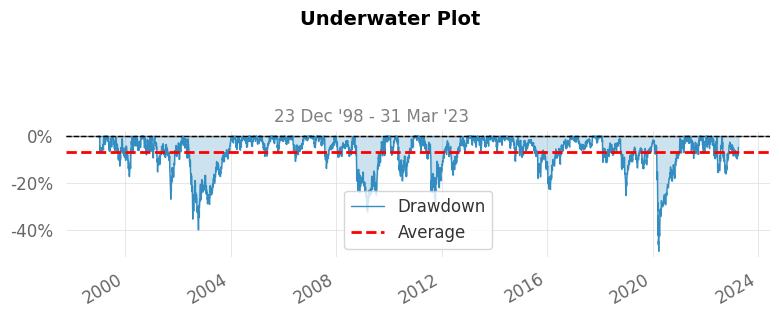

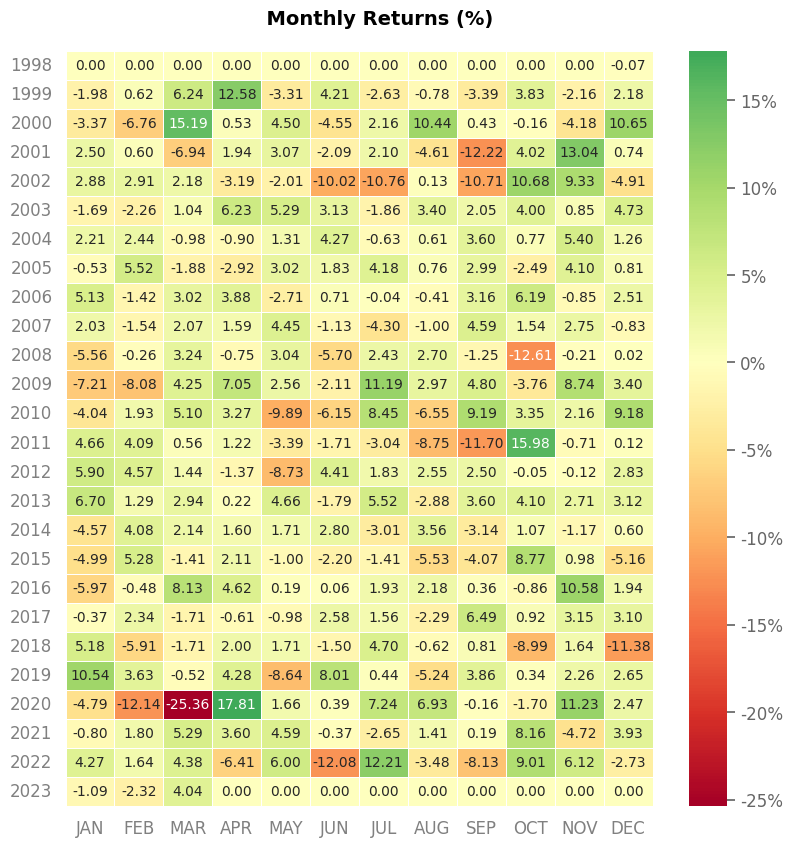

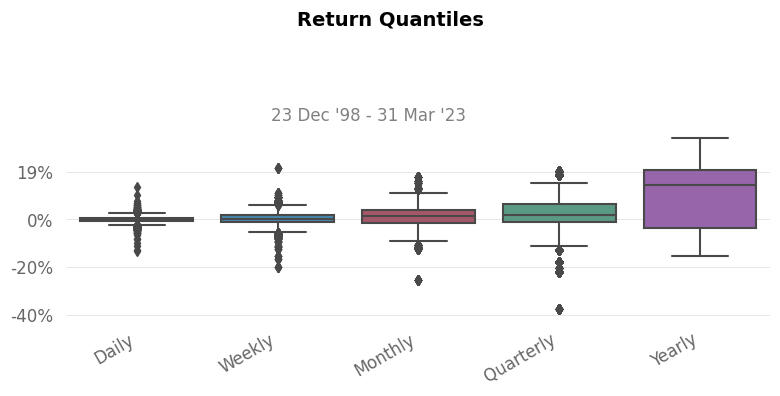

In [13]:
qs.reports.full(df_strat, benchmark = market)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               1998-12-23  1998-12-23
End Period                 2023-03-31  2023-03-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          829.89%     410.32%
CAGR﹪                     9.62%       6.94%

Sharpe                     0.55        0.44
Prob. Sharpe Ratio         99.65%      98.46%
Smart Sharpe               0.52        0.42
Sortino                    0.78        0.62
Smart Sortino              0.74        0.59
Sortino/√2                 0.55        0.44
Smart Sortino/√2           0.52        0.42
Omega                      1.11        1.11

Max Drawdown               -49.29%     -55.19%
Longest DD Days            1141        2404
Volatility (ann.)          20.5%       19.75%
R^2                        0.7         0.7
Information Ratio          0.01        0.01
Calmar                     0.2        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-01-29,2020-03-23,2021-03-15,1141,-49.285734,-41.476145
2,2002-03-20,2002-10-09,2004-01-16,667,-40.103601,-35.052304
3,2008-09-15,2009-03-09,2009-11-16,427,-32.387546,-31.272882
4,2011-05-02,2011-10-03,2012-09-14,501,-28.457810,-25.813002
5,2001-02-13,2001-09-21,2002-02-26,378,-26.964859,-23.214534


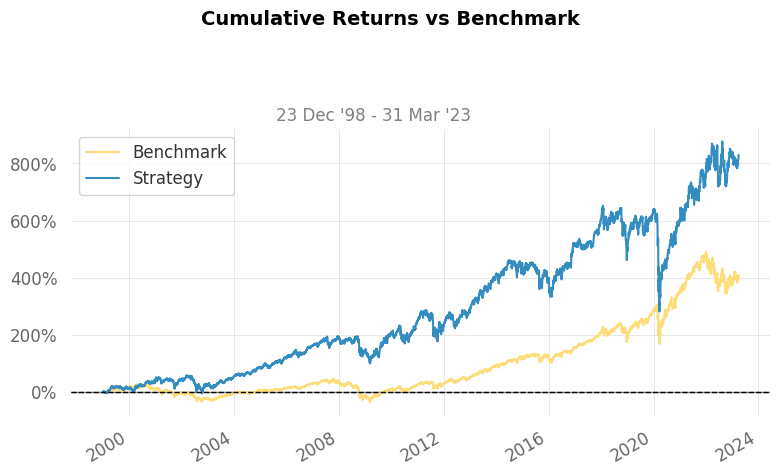

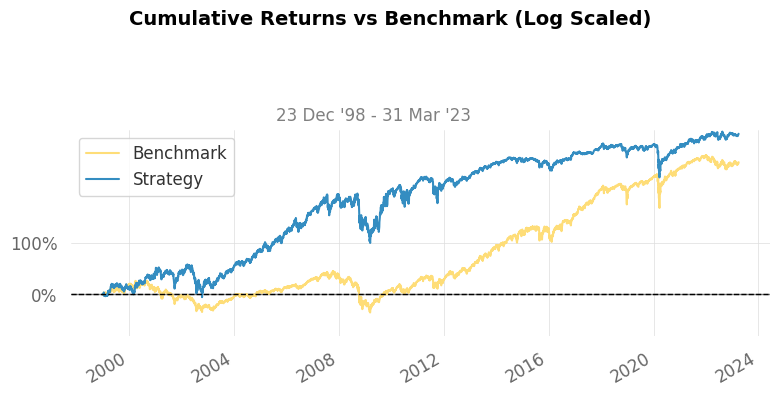

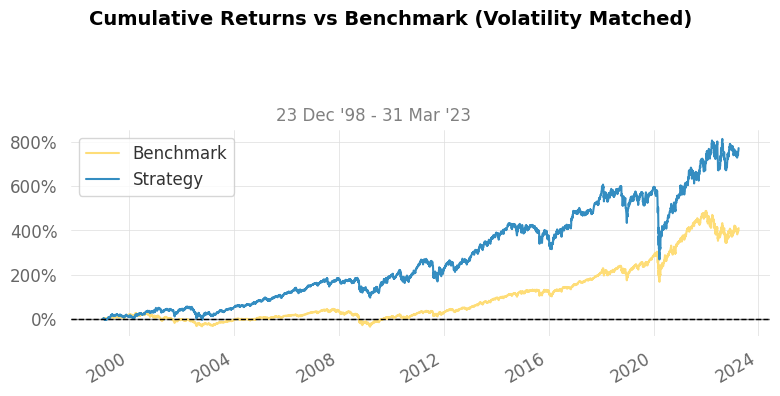

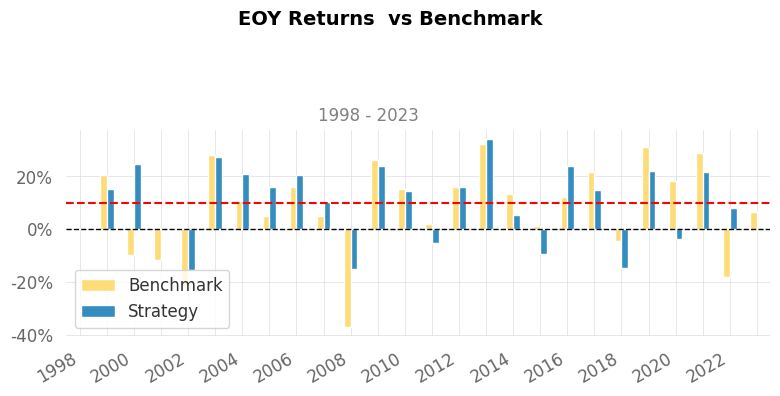

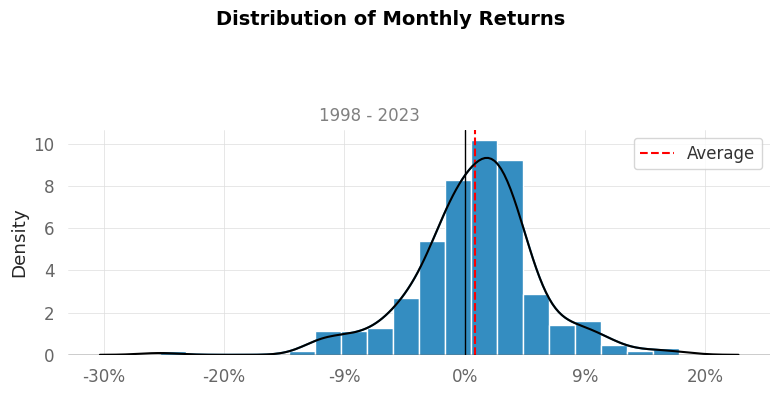

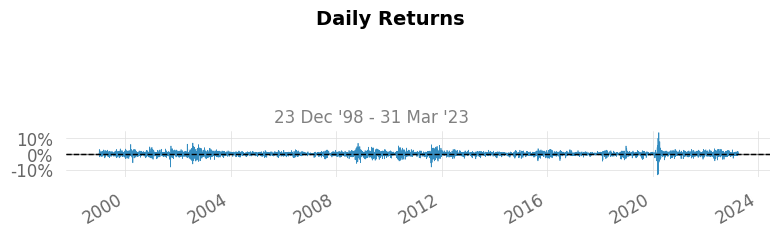

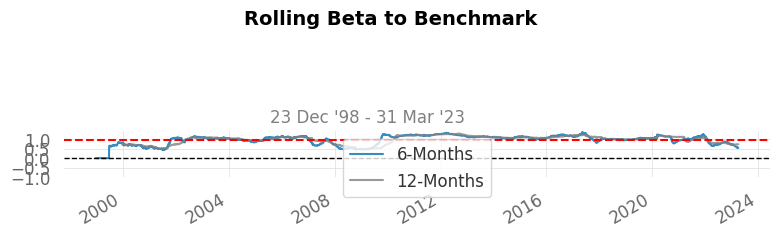

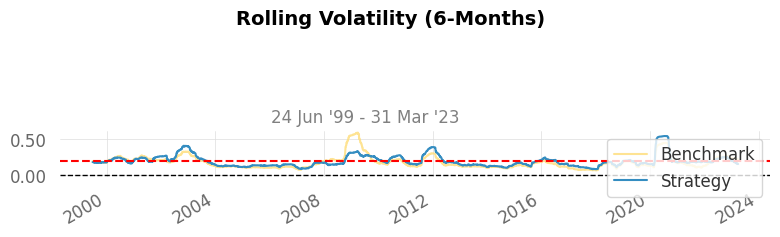

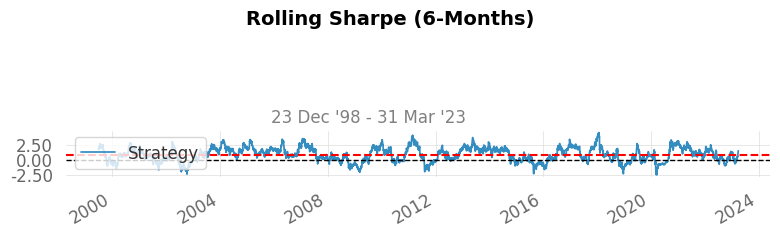

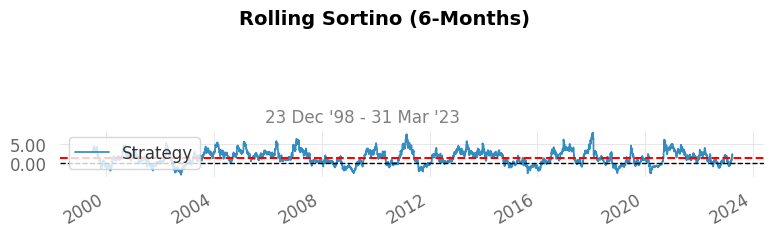

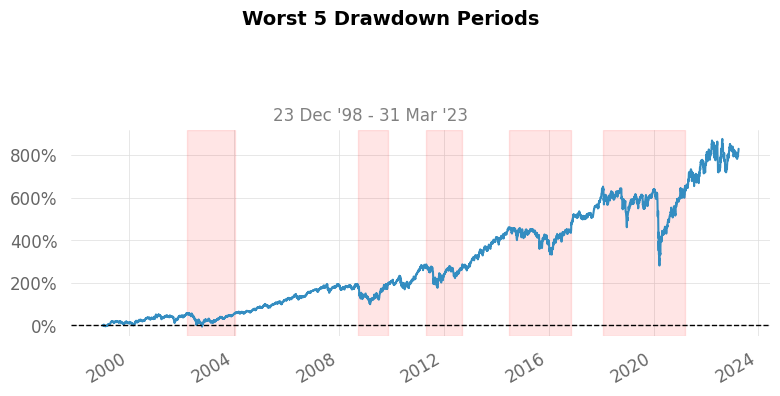

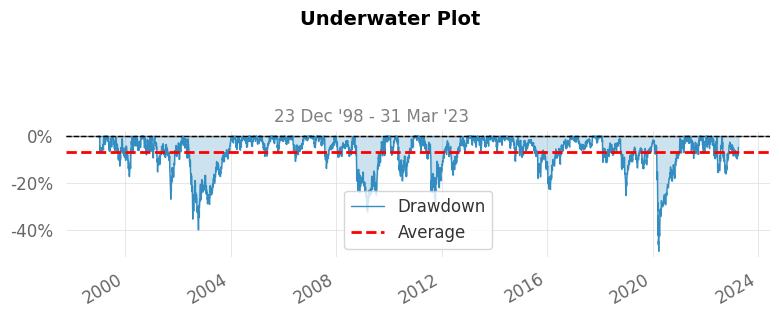

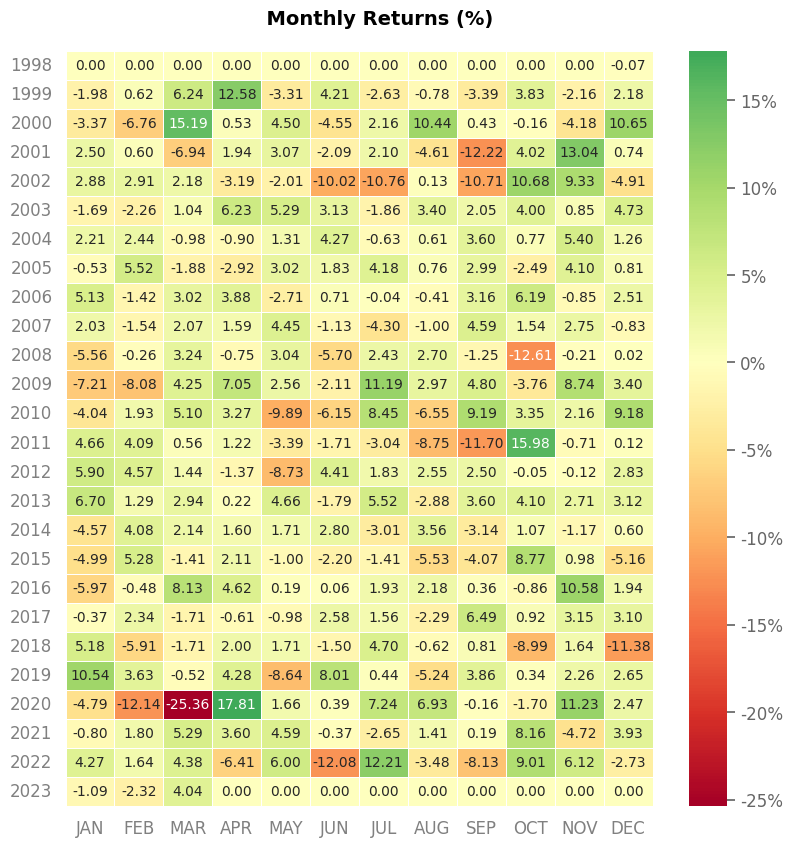

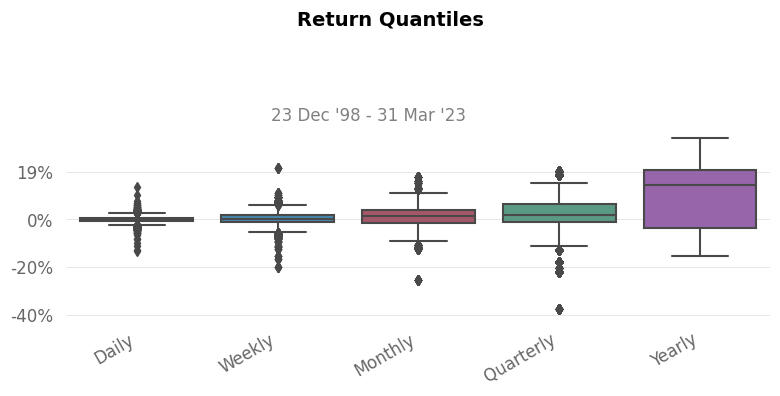

In [14]:
df_metrics = pd.DataFrame()
df_metrics = qs.reports.full(df_strat, display = True, benchmark = market)

In [15]:
LEI_df[LEI_df['LEI(YoY)_restored']>0].mean()
LEI_df[LEI_df['LEI(YoY)_restored']<0].mean()

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


LEI(YoY)_raw        -119.730138
LEI(YoY)_restored     -0.055863
High                   0.070000
Low                   -0.030000
peak                   0.060729
trough                -0.114660
slope                 -0.162906
condition              1.500000
dtype: float64